In [1]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from sklearn import preprocessing

import math

from sklearn import linear_model
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import median_absolute_error
from sklearn.metrics import r2_score
from random import shuffle

In [2]:
music_df = pd.read_csv('../music_data/dataset-12-4.csv', na_values=['NA'])

In [3]:
music_df.describe(include='all')

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity
count,987.000000,987.000000,987,987,987.000000,9.870000e+02,987.000000,9.870000e+02,987.000000
unique,NaN,NaN,543,975,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,The Beatles,Wipe Out,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,23,2,NaN,NaN,NaN,NaN,NaN
mean,50.496454,11.708669,NaN,NaN,1964.513678,8.002504e+06,3359.658561,3.070148e+05,50.770010
std,28.955074,12.776220,NaN,NaN,2.879346,2.003319e+07,3957.353059,8.630158e+05,19.024026
min,1.000000,4.786301,NaN,NaN,1960.000000,1.728000e+03,108.000000,1.900000e+01,4.000000
25%,25.000000,5.761896,NaN,NaN,1962.000000,2.501365e+05,951.000000,4.236000e+03,36.000000
50%,50.000000,7.562751,NaN,NaN,1965.000000,9.563520e+05,1952.000000,2.805400e+04,52.000000
75%,75.500000,11.949771,NaN,NaN,1967.000000,5.058133e+06,4169.000000,1.207250e+05,65.000000


# 1. Visualization

## 1.1 Correlation Analysis

In [4]:
# Pearson correlation analysis
correlation = music_df.corr(method='pearson')
correlation

,Rank,RankPowerlaw,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity
Rank,1.000000,-0.627802,0.005052,-0.162621,-0.039100,-0.051907,-0.053328
RankPowerlaw,-0.627802,1.000000,0.001235,0.164608,0.080313,0.104210,0.079048
Year,0.005052,0.001235,1.000000,0.165336,0.119429,0.126959,0.177349
SpotifyPlayCount,-0.162621,0.164608,0.165336,1.000000,0.363790,0.366317,0.412784
WikiWordCount,-0.039100,0.080313,0.119429,0.363790,1.000000,0.686052,0.673945
Followers,-0.051907,0.104210,0.126959,0.366317,0.686052,1.000000,0.557748
Popularity,-0.053328,0.079048,0.177349,0.412784,0.673945,0.557748,1.000000


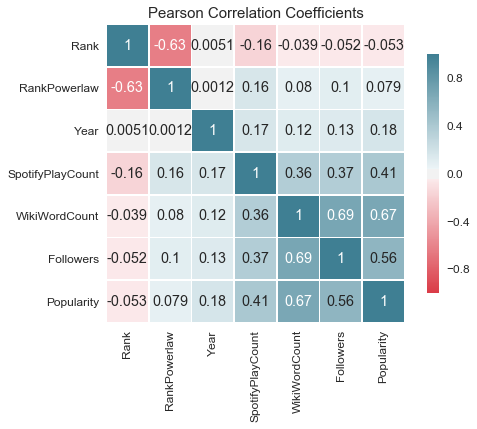

In [5]:
sns.set(style="white", font_scale=1.2)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Plot the Pearson correlation heatmap
ax = sns.heatmap(correlation, cmap=cmap, annot=True, center=0, 
                 square=True, linewidths=.7, cbar_kws={"shrink": .8})
plt.yticks(rotation=0) 
ax.set_title('Pearson Correlation Coefficients', fontsize=15)

# plt.savefig('../figure/correlation_heatmap.png')

In [6]:
# Pearson correlation analysis - log(SpotifyPlayCount)
music_df_logtarget = music_df.copy()
music_df_logtarget.SpotifyPlayCount = np.log(music_df_logtarget.SpotifyPlayCount)
correlation_logtarget = music_df_logtarget.corr(method='pearson')
correlation_logtarget

,Rank,RankPowerlaw,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity
Rank,1.000000,-0.627802,0.005052,-0.274270,-0.039100,-0.051907,-0.053328
RankPowerlaw,-0.627802,1.000000,0.001235,0.231408,0.080313,0.104210,0.079048
Year,0.005052,0.001235,1.000000,0.270640,0.119429,0.126959,0.177349
SpotifyPlayCount,-0.274270,0.231408,0.270640,1.000000,0.474928,0.396364,0.664083
WikiWordCount,-0.039100,0.080313,0.119429,0.474928,1.000000,0.686052,0.673945
Followers,-0.051907,0.104210,0.126959,0.396364,0.686052,1.000000,0.557748
Popularity,-0.053328,0.079048,0.177349,0.664083,0.673945,0.557748,1.000000


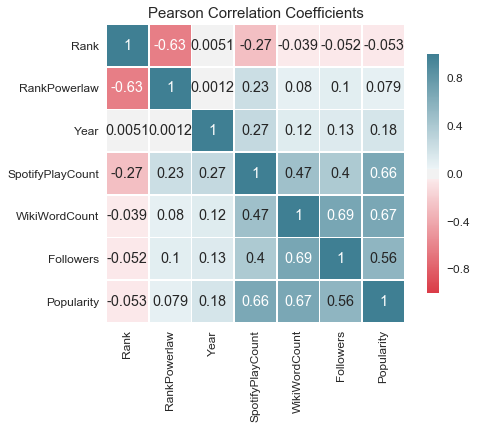

In [7]:
sns.set(style="white", font_scale=1.2)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Plot the Pearson correlation heatmap
ax = sns.heatmap(correlation_logtarget, cmap=cmap, annot=True, center=0, 
                 square=True, linewidths=.7, cbar_kws={"shrink": .8})
plt.yticks(rotation=0) 
ax.set_title('Pearson Correlation Coefficients', fontsize=15)

plt.savefig('../figure/correlation_heatmap_target.png', bbox_inches='tight')

## 1.2 Plots

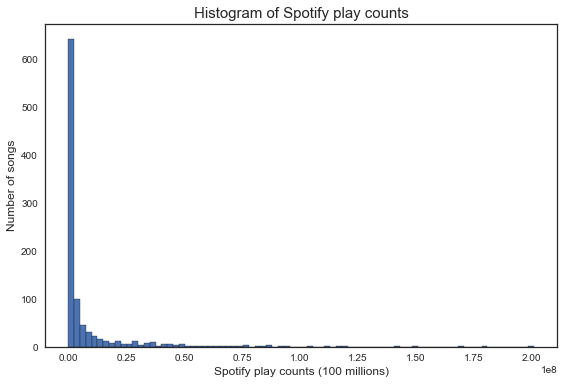

Mean:  8002504.149949341
Std:  20033193.8982334


In [10]:
# Plot . Histogram of SpotifyPlayCounts
sns.set(style="white")

num_bins = 80
fig = plt.figure()
ax = plt.subplot()
n, bins, patches = ax.hist(music_df.SpotifyPlayCount, num_bins, edgecolor='black')

ax.set_xlabel('Spotify play counts (100 millions)', fontsize=12)
ax.set_ylabel('Number of songs', fontsize=12)
ax.set_title('Histogram of Spotify play counts', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', music_df.SpotifyPlayCount.mean())
print('Std: ', music_df.SpotifyPlayCount.std())

# fig.savefig('../figure/hist_spotifyplaycount.png')

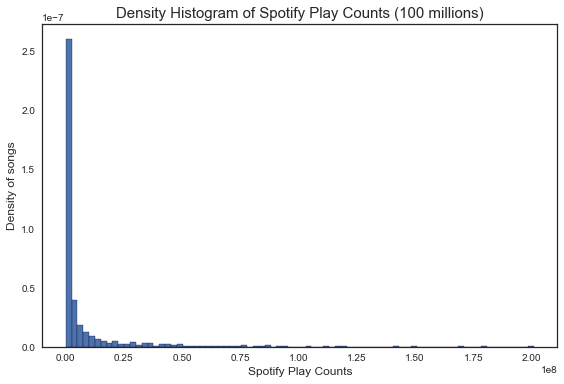

Mean:  7899715.501
Std:  19922589.896896116


In [9]:
# Test #
# Plot . Density Histogram of SpotifyPlayCounts
sns.set(style="white")

num_bins = 80
fig = plt.figure()
ax = plt.subplot()
n, bins, patches = ax.hist(music_df.SpotifyPlayCount, num_bins, normed=True, edgecolor='black')

ax.set_xlabel('Spotify Play Counts', fontsize=12)
ax.set_ylabel('Density of songs', fontsize=12)
ax.set_title('Density Histogram of Spotify Play Counts (100 millions)', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', music_df.SpotifyPlayCount.mean())
print('Std: ', music_df.SpotifyPlayCount.std())

# fig.savefig('../figure/hist_density_spotifyplaycount.png')

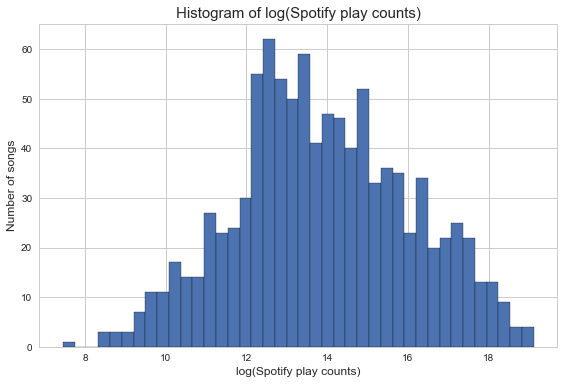

Mean:  13.894323604399096
Std:  2.16954222710455


In [44]:
# Plot . Histogram of log(SpotifyPlayCounts)
sns.set(style="whitegrid")

num_bins = 40
fig = plt.figure()
ax = plt.subplot()
n, bins, patches = ax.hist(np.log(music_df.SpotifyPlayCount), num_bins, edgecolor='black')

ax.set_xlabel('log(Spotify play counts)', fontsize=12)
ax.set_ylabel('Number of songs', fontsize=12)
ax.set_title('Histogram of log(Spotify play counts)', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', np.log(music_df.SpotifyPlayCount).mean())
print('Std: ', np.log(music_df.SpotifyPlayCount).std())

# fig.savefig('../figure/hist_log_spotifyplaycount.png', bbox_inches='tight')

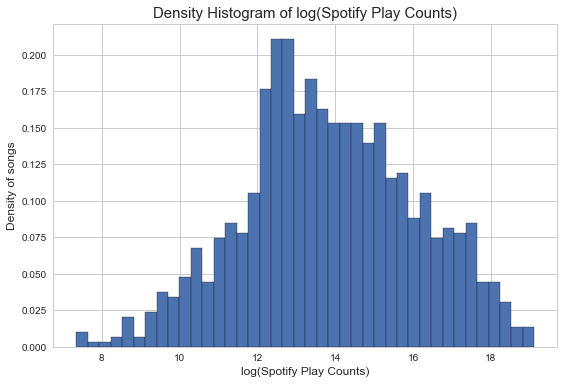

Mean:  13.84261285102407
Std:  2.213413059222591


In [11]:
# Test #
# Plot . Density Histogram of log(SpotifyPlayCounts)
sns.set(style="whitegrid")

num_bins = 40
fig = plt.figure()
ax = plt.subplot()
n, bins, patches = ax.hist(np.log(music_df.SpotifyPlayCount), num_bins, normed=True, edgecolor='black')

ax.set_xlabel('log(Spotify Play Counts)', fontsize=12)
ax.set_ylabel('Density of songs', fontsize=12)
ax.set_title('Density Histogram of log(Spotify Play Counts)', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', np.log(music_df.SpotifyPlayCount).mean())
print('Std: ', np.log(music_df.SpotifyPlayCount).std())

fig.savefig('../figure/hist_density_log_spotifyplaycount.png')

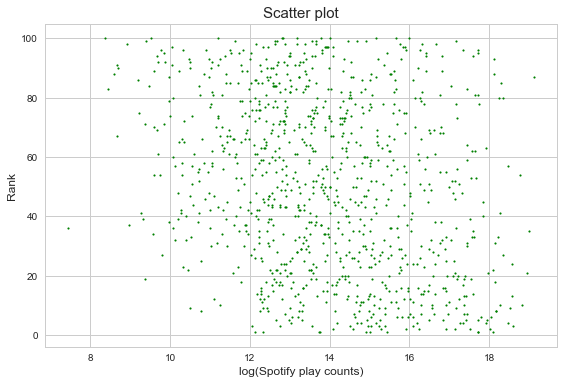

In [12]:
# Plot . Scatter plot of Rank and log(SpotifyPlayCounts)
sns.set(style="whitegrid")

fig = plt.figure()
ax = plt.subplot()
ax.scatter(np.log(music_df.SpotifyPlayCount), music_df.Rank, 
           s=3, color='green')

ax.set_xlabel('log(Spotify play counts)', fontsize=12)
ax.set_ylabel('Rank', fontsize=12)
ax.set_title('Scatter plot', fontsize=15)

plt.tight_layout()
plt.show()

# fig.savefig('../figure/scatter_logspotifyplaycount_rank.png')

In [13]:
# Find a song with the highest Spotify play counts
music_df.SpotifyPlayCount.max()
music_df.loc[music_df['SpotifyPlayCount'] == music_df.SpotifyPlayCount.max()]

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,followers,popularity
826,87,5.247075,Marvin Gaye and Tammi Terrell,Ain't No Mountain High Enough,1967,201057355,365,1503529,77


/Users/haenalee/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


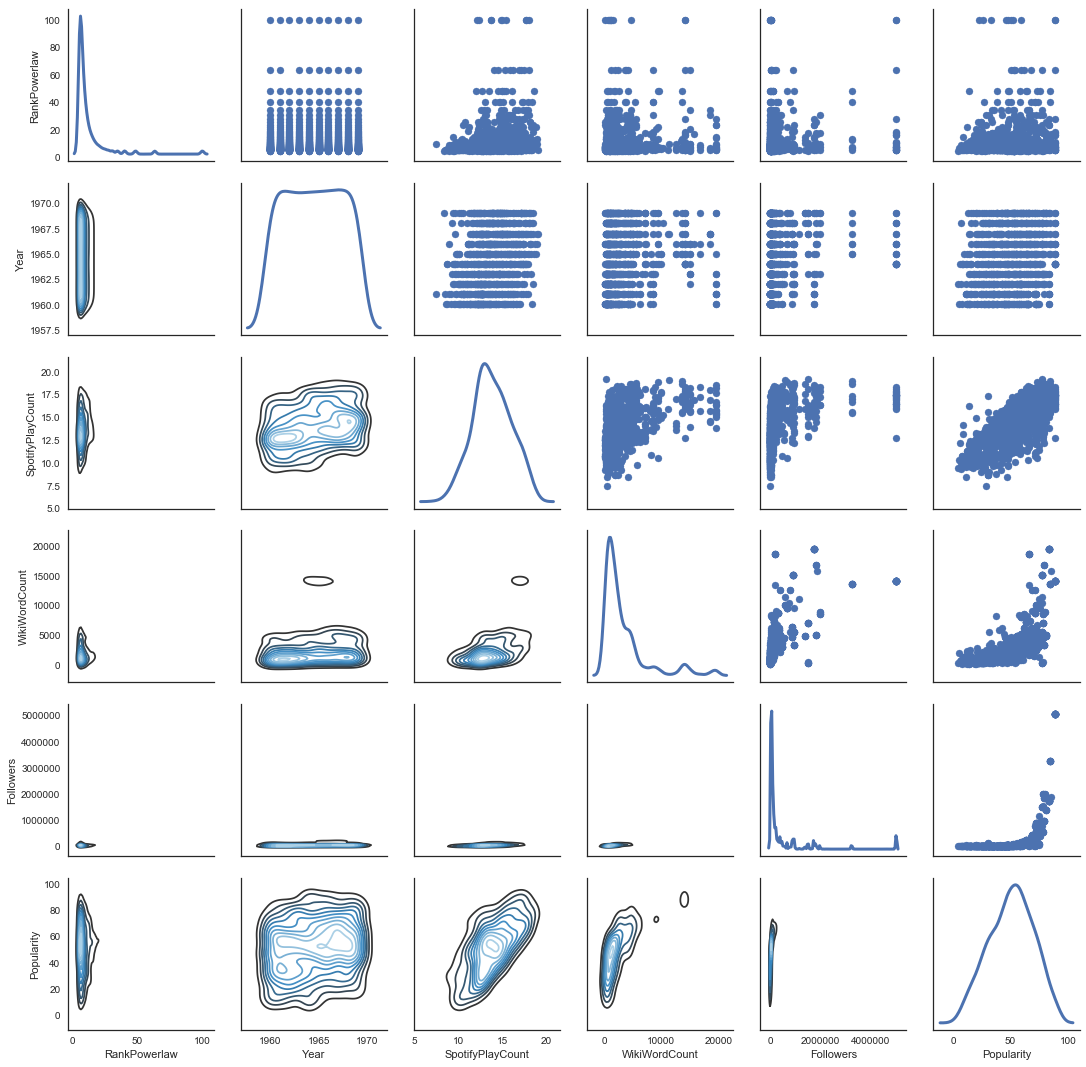

In [11]:
# Paired Density and Scatterplot Matrix
sns.set(style="white")

# df = sns.load_dataset("iris")
# df = music_df_logtarget.copy()
df = music_df_logtarget[['RankPowerlaw','Year','SpotifyPlayCount','WikiWordCount',
                         'Followers','Popularity']].copy()

g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

# 2. Data Scraping

## 2.1 Extract Artist (artist name) column

In [38]:
# Extract Artist column - File 'billboard_artist_name.csv'
artist_df = pd.DataFrame(music_df.Artist.unique())
artist_df.columns = ['Artist']

In [40]:
artist_df.to_csv('../music_data/billboard_artist_name.csv', sep=',', index=False)

## 2.2 Wikipedia package - Artist page scraping

Scrape URL and wikipedia word count (WikiWordCount)

python code : wikipedia_scrape_url_wc.py

result file : billboard_artist.csv

# 3. Model

## 3.1 Preprocessing - Progress Report

In [15]:
# Read artist dataset
artist_df = pd.read_csv('../music_data/billboard_artist_wordcount.csv', na_values=['NA'])

In [16]:
artist_df.describe(include='all')

,Artist,WikiWordCount
count,547,547.000000
unique,547,NaN
top,Sounds Orchestral,NaN
freq,1,NaN
mean,NaN,2166.974406
std,NaN,2617.383243
min,NaN,108.000000
25%,NaN,651.000000
50%,NaN,1278.000000
75%,NaN,2541.000000


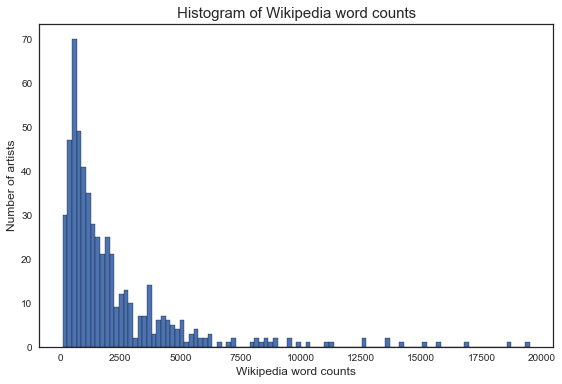

Mean:  2166.9744058500914
Std:  2617.383243489533


In [17]:
# Plot . Histogram of Wikipedia word count
sns.set(style="white")

num_bins = 100
fig = plt.figure()
ax = plt.subplot()
n, bins, patches = ax.hist(artist_df.WikiWordCount, num_bins, edgecolor='black')

ax.set_xlabel('Wikipedia word counts', fontsize=12)
ax.set_ylabel('Number of artists', fontsize=12)
ax.set_title('Histogram of Wikipedia word counts', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', artist_df.WikiWordCount.mean())
print('Std: ', artist_df.WikiWordCount.std())

fig.savefig('../figure/hist_wikiwordcount.png')

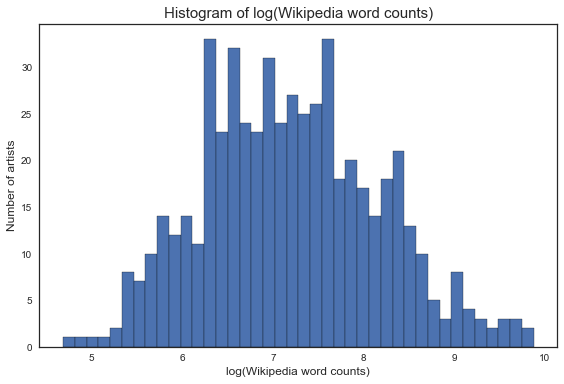

Mean:  7.199045109926113
Std:  0.9639198424125061


In [18]:
# Plot . Histogram of log(WikipediaWordCount)
sns.set(style="white")

num_bins = 40
fig = plt.figure()
ax = plt.subplot()
n, bins, patches = ax.hist(np.log(artist_df.WikiWordCount), num_bins, edgecolor='black')

ax.set_xlabel('log(Wikipedia word counts)', fontsize=12)
ax.set_ylabel('Number of artists', fontsize=12)
ax.set_title('Histogram of log(Wikipedia word counts)', fontsize=15)

plt.tight_layout()
plt.show()

print('Mean: ', np.log(artist_df.WikiWordCount).mean())
print('Std: ', np.log(artist_df.WikiWordCount).std())

fig.savefig('../figure/hist_log_wikiwordcount.png')

In [19]:
music_dataset = pd.merge(music_df_logtarget, artist_df, on='Artist')
music_dataset.describe(include='all')

,Rank,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
count,1000.000000,1000,1000,1000.000000,1000.000000,1000.000000
unique,NaN,547,987,NaN,NaN,NaN
top,NaN,The Beatles,Wipe Out,NaN,NaN,NaN
freq,NaN,23,2,NaN,NaN,NaN
mean,50.547000,NaN,NaN,1964.501000,13.842613,3361.737000
std,28.922799,NaN,NaN,2.875111,2.213413,3937.524284
min,1.000000,NaN,NaN,1960.000000,7.348588,108.000000
25%,25.750000,NaN,NaN,1962.000000,12.403722,951.000000
50%,50.500000,NaN,NaN,1964.500000,13.669471,1942.500000
75%,76.000000,NaN,NaN,1967.000000,15.417700,4194.000000


In [20]:
# Pearson correlation analysis
correlation = music_dataset.corr(method='pearson')
correlation

,Rank,Year,SpotifyPlayCount,WikiWordCount
Rank,1.000000,0.002575,-0.266992,-0.037377
Year,0.002575,1.000000,0.271174,0.118884
SpotifyPlayCount,-0.266992,0.271174,1.000000,0.462173
WikiWordCount,-0.037377,0.118884,0.462173,1.000000


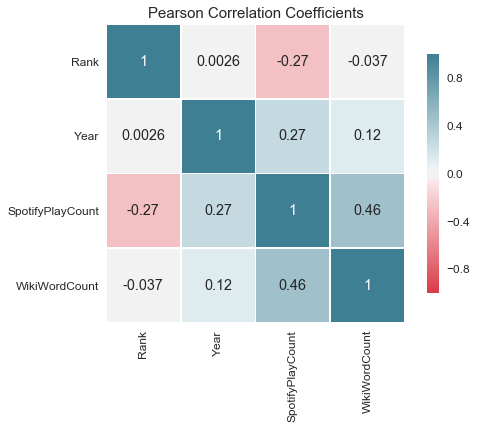

In [21]:
sns.set(style="white", font_scale=1.2)

# Generate a custom diverging colormap
cmap = sns.diverging_palette(10, 220, as_cmap=True)

# Plot the Pearson correlation heatmap
ax = sns.heatmap(correlation, cmap=cmap, annot=True, center=0, 
                 square=True, linewidths=.7, cbar_kws={"shrink": .8})
plt.yticks(rotation=0) 
ax.set_title('Pearson Correlation Coefficients', fontsize=15)

plt.savefig('../figure/correlation_heatmap_logtarget_wwc.png')

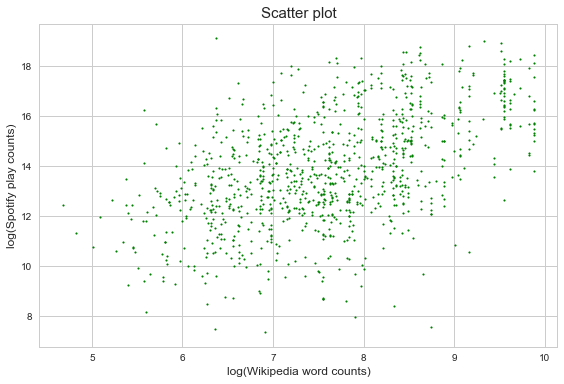

In [22]:
# Plot . Scatter plot of WikiWordCount and log(SpotifyPlayCounts)
sns.set(style="whitegrid")

fig = plt.figure()
ax = plt.subplot()
#ax.scatter(music_dataset.SpotifyPlayCount, np.log(music_dataset.WikiWordCount), 
#           s=3, color='green')
ax.scatter(np.log(music_dataset.WikiWordCount), music_dataset.SpotifyPlayCount,
           s=3, color='green')

#ax.set_xlabel('log(Spotify play counts)', fontsize=12)
#ax.set_ylabel('log(Wikipedia word counts)', fontsize=12)
ax.set_xlabel('log(Wikipedia word counts)', fontsize=12)
ax.set_ylabel('log(Spotify play counts)', fontsize=12)
ax.set_title('Scatter plot', fontsize=15)

plt.tight_layout()
plt.show()

#fig.savefig('../figure/scatter_logspotifyplaycount_logwikiwc.png')
fig.savefig('../figure/scatter_logwikiwc_logspotifyplaycount.png')

In [23]:
music_dataset_norm = music_dataset.copy()

In [24]:
music_dataset_norm.WikiWordCount = np.log(music_dataset_norm.WikiWordCount)

In [12]:
def z_score_norm(df, feature_list):
    """ Dot the z-score method on selected features in feature_list. 
        z = (x - mean)/std
    
    Args:
        df (pandas.DataFrame): data set
        feature_list   (list): a list of features, each element is a string
    """
    
    for col in feature_list:
        df[col] = (df[col] - df[col].mean())/(df[col].std())

In [26]:
z_score_norm(music_dataset_norm, feature_list=['Rank','Year','WikiWordCount'])

In [55]:
music_dataset_norm.describe(include='all')

,Rank,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
count,1.000000e+03,1000,1000,1.000000e+03,1000.000000,1.000000e+03
unique,NaN,547,987,NaN,NaN,NaN
top,NaN,The Beatles,Baby It's You,NaN,NaN,NaN
freq,NaN,23,2,NaN,NaN,NaN
mean,2.797762e-17,NaN,NaN,1.023182e-14,13.842613,8.594347e-15
std,1.000000e+00,NaN,NaN,1.000000e+00,2.213413,1.000000e+00
min,-1.713078e+00,NaN,NaN,-1.565505e+00,7.348588,-2.788130e+00
25%,-8.573513e-01,NaN,NaN,-8.698794e-01,12.403722,-6.998582e-01
50%,-1.625016e-03,NaN,NaN,-3.478126e-04,13.669471,-1.425531e-02
75%,8.800324e-01,NaN,NaN,8.691837e-01,15.417700,7.246168e-01


## [Final Report ] 3.1 Preprocessing

In [24]:
def powerlaw_rank(df_music):
    ''' Do powerlaw on the original rank.
        y = 100*rank^(-0.66)
        However, I find that differnent coefficient and exponent do not affect MAE. Don't know why.
    
    Args:
        df_music (pandas.DataFrame): dataset
    '''
    
    df_music.insert(1, 'RankPowerlaw', df_music.Rank)  # insert right next to column 'Rank'
    df_music['RankPowerlaw'] = df_music['RankPowerlaw'].astype('float')
    for i in range(0, len(df_music)):
        df_music.iat[i,1] = 100 * math.pow(df_music.iat[i,1], -0.66)

In [13]:
music_dataset = music_df_logtarget.copy()
music_dataset.describe(include='all')

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity
count,987.000000,987.000000,987,987,987.000000,987.000000,987.000000,9.870000e+02,987.000000
unique,NaN,NaN,543,975,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,The Beatles,Wipe Out,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,23,2,NaN,NaN,NaN,NaN,NaN
mean,50.496454,11.708669,NaN,NaN,1964.513678,13.894324,3359.658561,3.070148e+05,50.770010
std,28.955074,12.776220,NaN,NaN,2.879346,2.169542,3957.353059,8.630158e+05,19.024026
min,1.000000,4.786301,NaN,NaN,1960.000000,7.454720,108.000000,1.900000e+01,4.000000
25%,25.000000,5.761896,NaN,NaN,1962.000000,12.429750,951.000000,4.236000e+03,36.000000
50%,50.000000,7.562751,NaN,NaN,1965.000000,13.770881,1952.000000,2.805400e+04,52.000000
75%,75.500000,11.949771,NaN,NaN,1967.000000,15.436479,4169.000000,1.207250e+05,65.000000


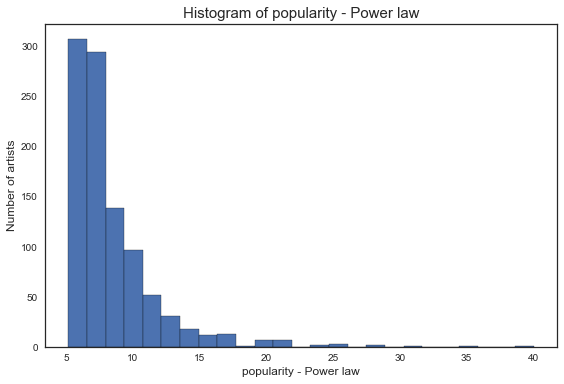

In [15]:
# Plot . Histogram of log(WikipediaWordCount)
sns.set(style="white")

num_bins = 25
fig = plt.figure()
ax = plt.subplot()
# popularityPowerlaw = 100 * math.pow(float(music_dataset.popularity), -0.66)
popularityPowerlaw = music_dataset.Popularity.astype('float')
for i in range(0, popularityPowerlaw.size):
    popularityPowerlaw.iloc[i] = 100 * math.pow(popularityPowerlaw.iloc[i], -0.66)
n, bins, patches = ax.hist(popularityPowerlaw, num_bins, edgecolor='black')

ax.set_xlabel('popularity - Power law', fontsize=12)
ax.set_ylabel('Number of artists', fontsize=12)
ax.set_title('Histogram of popularity - Power law', fontsize=15)

plt.tight_layout()
plt.show()

# print('Mean: ', music_dataset.popularityPowerlaw.mean())
# print('Std: ', music_dataset.popularityPowerlaw.std())

# fig.savefig('../figure/hist_popularityPowerlaw.png')

In [16]:
music_dataset_norm = music_dataset.copy()

In [17]:
# log transformation on features: RankPowerlaw, WikiWordCount, Followers
music_dataset_norm.RankPowerlaw = np.log(music_dataset_norm.RankPowerlaw)
music_dataset_norm.WikiWordCount = np.log(music_dataset_norm.WikiWordCount)
music_dataset_norm.Followers = np.log(music_dataset_norm.Followers)

In [ ]:
# Test - CHECK #
power law transform on
popularity

then log

In [18]:
z_score_norm(music_dataset_norm, feature_list=['RankPowerlaw','Year','WikiWordCount',
                                               'Followers','Popularity'])

In [19]:
music_dataset_norm.describe(include='all')

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount,Followers,Popularity
count,987.000000,9.870000e+02,987,987,9.870000e+02,987.000000,9.870000e+02,9.870000e+02,9.870000e+02
unique,NaN,NaN,543,975,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,The Beatles,Wipe Out,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,23,2,NaN,NaN,NaN,NaN,NaN
mean,50.496454,-7.588436e-15,NaN,NaN,-2.273449e-14,13.894324,3.276451e-15,-5.255843e-17,-3.096139e-17
std,28.955074,1.000000e+00,NaN,NaN,1.000000e+00,2.169542,1.000000e+00,1.000000e+00,1.000000e+00
min,1.000000,-1.048517e+00,NaN,NaN,-1.567605e+00,7.454720,-2.759147e+00,-2.731795e+00,-2.458471e+00
25%,25.000000,-7.442209e-01,NaN,NaN,-8.730030e-01,12.429750,-6.872390e-01,-6.532938e-01,-7.763872e-01
50%,50.000000,-2.980635e-01,NaN,NaN,1.689002e-01,13.770881,-2.347950e-03,7.344527e-02,6.465455e-02
75%,75.500000,4.523902e-01,NaN,NaN,8.635024e-01,15.436479,7.203795e-01,6.344528e-01,7.480010e-01


/Users/haenalee/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


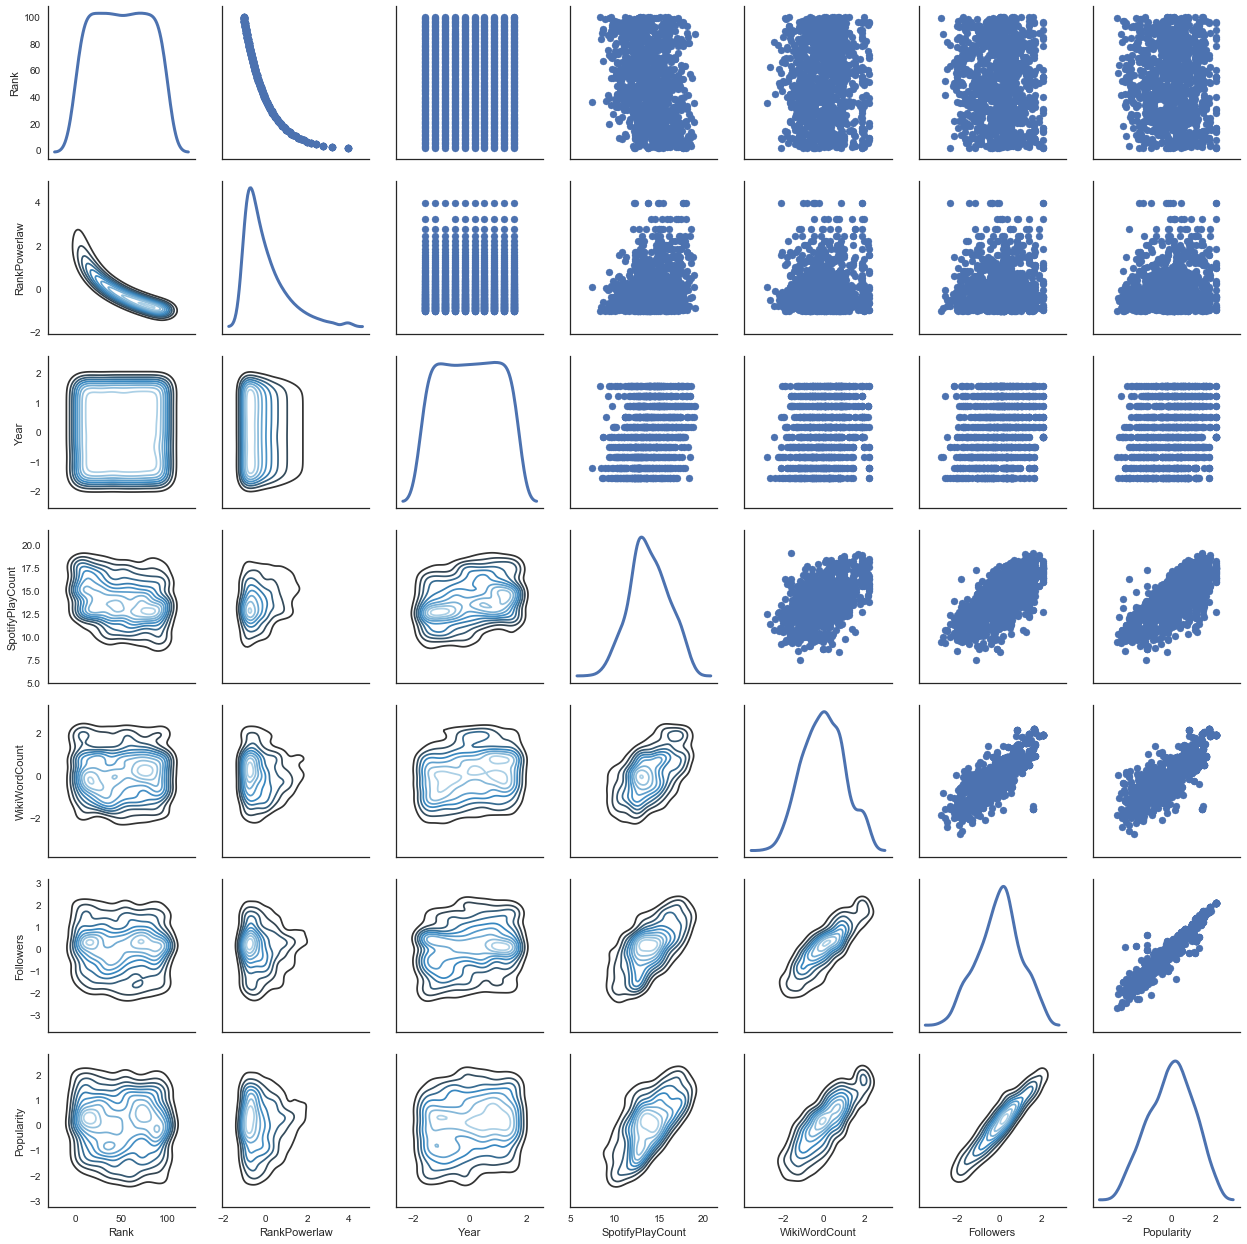

In [20]:
# Paired Density and Scatterplot Matrix
sns.set(style="white")

# df = sns.load_dataset("iris")
df = music_dataset_norm.copy()

g = sns.PairGrid(df, diag_sharey=False)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_upper(plt.scatter)
g.map_diag(sns.kdeplot, lw=3)

## 3.2  Baseline model - Linear regression

In [56]:
feature_base = music_dataset_norm.loc[:,['Rank','Year']]
target = music_dataset_norm.loc[:,'SpotifyPlayCount']

In [57]:
linear_regr_base = linear_model.LinearRegression()

In [21]:
def performance_statistics(model_name, target, pred):
    '''Plot a table of performance statistics
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    mae   = mean_absolute_error(target, pred)
    medae = median_absolute_error(target, pred)
    r2    = r2_score(target, pred)
    
    columns = ['Model', 'Mean Absolute Error', 'Median Absolute Error', 'R2 Score']
    cell_text = [['%s' % model_name, '%1.3f' % mae, '%1.3f' % medae, '%1.3f' % r2]]
    
    nrow = 1
    ncol = len(columns)
    
    fig = plt.figure(figsize=(ncol*2, nrow*0.2))
    ax = fig.add_subplot(111)
    ax.axis('off')
    
    table = ax.table(cellText=cell_text, colLabels=columns, loc='center')
    table.set_fontsize(14)
    table.scale(1.5, 1.5)
    
    fig.savefig('../figure/%s_stat_table.png' % model_name, bbox_inches='tight')

In [22]:
def error_distribution(model_name, target, pred):
    '''Plot a histogram of the error distribution
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    err = pred - target   # error is a Series
    min_err = err.min()
    max_err = err.max()
    fig = plt.figure()
    ax = err.plot.hist(bins=20, figsize=(7,7), edgecolor='black')
    ax.set_xticks(np.arange(math.floor(min_err), math.ceil(max_err)))
    ax.set_title('%s - Error Distribution' % model_name, fontsize=18)
    ax.set_xlabel('Error', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.grid()
    
    fig.savefig('../figure/%s_error_dist.png' % model_name, bbox_inches='tight')

In [23]:
def permutation_test(model_name, model, feature, target, pred):
    '''do permuation tests
    
    Args:
        model_name: model
        feature (DataFrame): feature data
        target (Series):  target data
        pred   (ndarray): predition results
    ''' 
    #pred = cross_val_predict(model, X=feature, y=target, cv=10)
    mae = mean_absolute_error(target, pred)
    mae_list = [mae]
    count = 0
    while count<100:
        count=count+1 
        target_to_list=target.tolist()
        shuffle(target_to_list)
        target_per = pd.DataFrame({'playcount':target_to_list})
        pred1 = cross_val_predict(model, X=feature, y=target_per, cv=10)
        mae_shuffle=mean_absolute_error(target,pred1)
        mae_list.append(mae_shuffle)
    num_bins = 20
    fig, ax = plt.subplots(figsize=(7,7))
    n, bins, patches = ax.hist(mae_list, num_bins, edgecolor='black')
    ax.set_title('%s - Permutation Test' % model_name, fontsize=18)
    #ax.set_xlabel('$Log(playcount)-mae$', fontsize=14)
    ax.set_xlabel('Target - Mean Absolute Error', fontsize=14)
    ax.set_ylabel('Counts', fontsize=14)
    ax.get_children()[0].set_color('r')
    ax.grid()
    
    fig.savefig('../figure/%s_permutation.png' % model_name, bbox_inches='tight')

In [24]:
def prediction_error_map(model_name, target, pred):
    '''Plot the prediction error map (similar to confusion matrices in classification problems)
    
    Args:
        target (Series):  target data
        pred   (ndarray): predition results
    '''
    y_min = target.min()*0.98
    y_max = target.max()*1.01
    fig, ax = plt.subplots(figsize=(7,7))
    #plt.scatter(target, pred, edgecolor='black', s=15)
    plt.scatter(target, pred, s=13)
    ax.plot([y_min, y_max], [y_min, y_max], 'k--', lw=2)
    ax.set_xticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_yticks(np.arange(math.floor(y_min),math.ceil(y_max)))
    ax.set_title('%s - Prediction Error Map' % model_name, fontsize=18)
    #ax.set_xlabel('Real Spotify (log) Play Count', fontsize=14)
    ax.set_xlabel('Target', fontsize=14)
    ax.set_ylabel('Prediction', fontsize=14)
    ax.axis([y_min,y_max,y_min,y_max])
    ax.grid()
    
    fig.savefig('../figure/%s_error_map.png' % model_name, bbox_inches='tight')

In [25]:
def evaluation(model, feature, target):
    """ Run the model on X and y using cross validation. Then output:
        1) performance statistics
        2) error distributions
        3) prediction error map
        4) permutation test
        
    Args:
        model   (object):    the machine learning object to fit the data
        feature (DataFrame): feature data
        target  (Series):    target  data
        
    This is version 0.11.10 (Nov. 10th)
    
    Todo:
        parameter "model" should be a list of models in the future
    """
    
    model_name = str(model)        # 'LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)'
    end = model_name.find('(')
    model_name = model_name[0:end] # 'LinearRegression'
    
    '''Do the prediction by cross validation'''
    pred = cross_val_predict(model, X=feature, y=target, cv=10)  # default is 10-fold
    
    print('This is the plots/reports of %s'  % model_name)
        
    error_distribution(model_name, target, pred)
    
    prediction_error_map(model_name, target, pred)
    
#     permutation_test(model_name, model, feature, target, pred)
    
    performance_statistics(model_name, target, pred)

In [68]:
sns.set(style="white")
evaluation(linear_regr_base, feature_base, target)

NameError: name 'target' is not defined

## [Final Report] 3.2 Baseline model - Linear regression

In [26]:
feature_base = music_dataset_norm.loc[:,['RankPowerlaw','Year']]
target_base = music_dataset_norm.loc[:,'SpotifyPlayCount']

In [27]:
linear_regr_base = linear_model.LinearRegression()

This is the plots/reports of LinearRegression


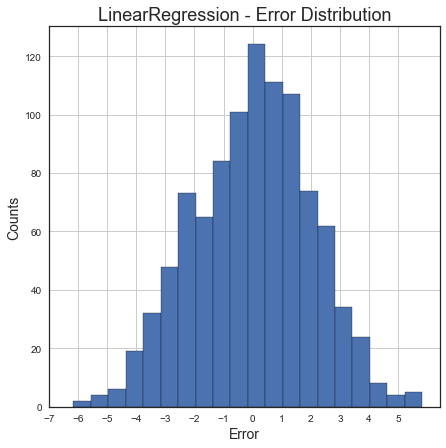

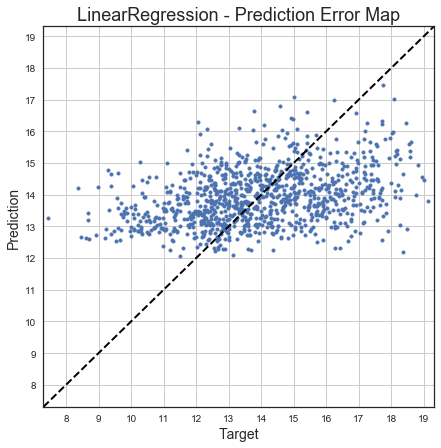

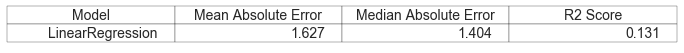

In [32]:
sns.set(style="white")
evaluation(linear_regr_base, feature_base, target_base)

## 3.3  Advanced model - Linear regression

In [62]:
feature = music_dataset_norm.loc[:,['Rank','Year','WikiWordCount']]
target = music_dataset_norm.loc[:,'SpotifyPlayCount']

In [91]:
linear_regr_adv = linear_model.LinearRegression()

This is the plots/reports of LinearRegression


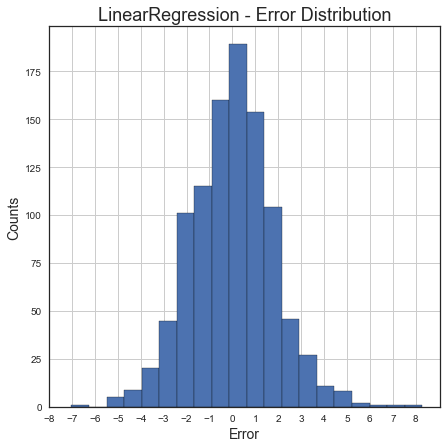

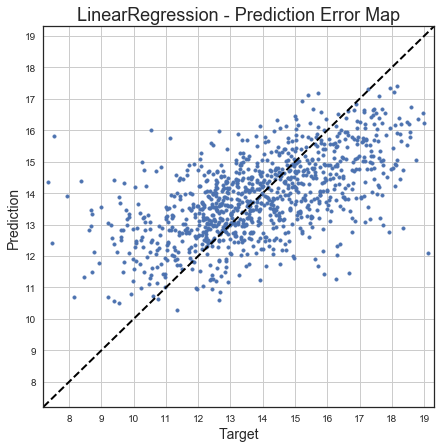

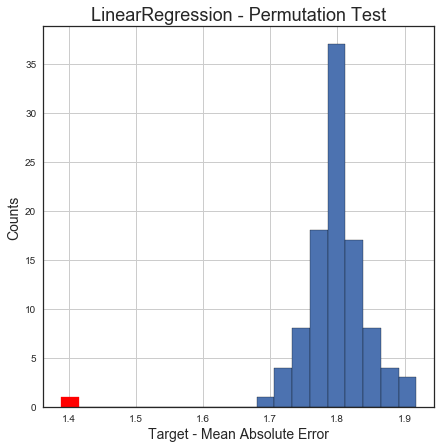

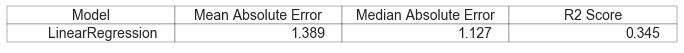

In [92]:
sns.set(style="white")
evaluation(linear_regr_adv, feature, target)

## 3.4 Advanced model - Support Vector Regression

In [63]:
svr_poly = SVR(kernel='linear', C=1e3)

This is the plots/reports of SVR


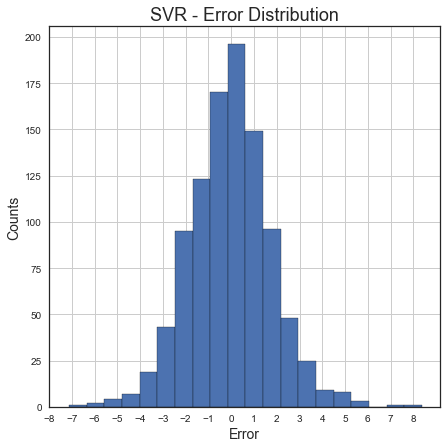

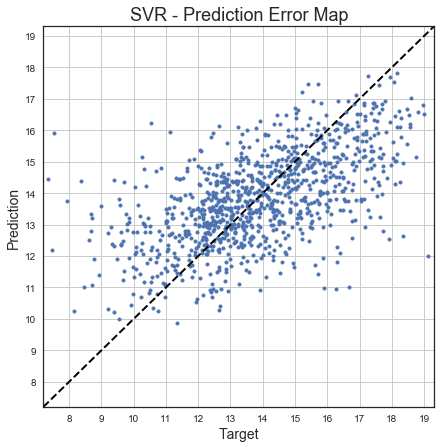

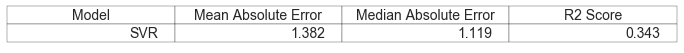

In [64]:
sns.set(style="white")
evaluation(svr_poly, feature, target)

## [Final Report] 3.3 Advanced model - Linear regression

In [29]:
feature_adv = music_dataset_norm.loc[:,['RankPowerlaw','Year','WikiWordCount',
                                        'Followers','Popularity']]
target_adv = music_dataset_norm.loc[:,'SpotifyPlayCount']

In [30]:
linear_regr_adv = linear_model.LinearRegression()

This is the plots/reports of LinearRegression


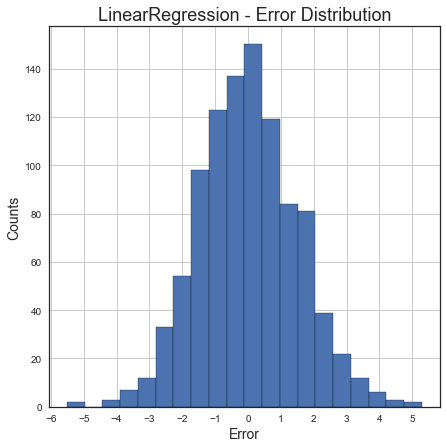

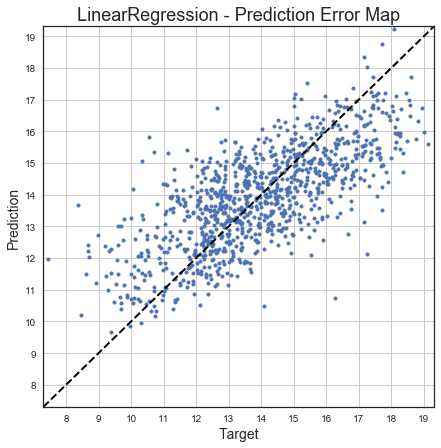

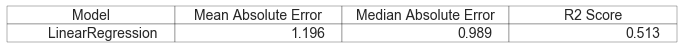

In [31]:
sns.set(style="white")
evaluation(linear_regr_adv, feature_adv, target_adv)

# 4. Further Data Scraping

1) Music CSV library from the CORGIS Dataset Project

In [40]:
#artist_df = pd.read_csv('../music_data/billboard_artist_name.csv', na_values=['NA'])
music_corgis_df = pd.read_csv('../../../Project/music_corgis.csv', na_values=['NA'])

result = pd.merge(music_df, music_corgis_df, how='left', 
                  left_on=['Artist','Title'], right_on=['artist.name','title'])

In [204]:
# result

In [42]:
music_corgis_join = result
music_corgis_join.to_csv('../music_data/music_corgis_join_artist-title.csv', sep=',', index=False)

In [43]:
result = pd.merge(music_df, music_corgis_df, how='left', 
                  left_on='Artist', right_on='artist.name')

In [205]:
# result

In [45]:
music_corgis_join = result
music_corgis_join.to_csv('../music_data/music_corgis_join_artist.csv', sep=',', index=False)

2) Beautiful Soup web scraping example

In [28]:
import bs4
#from urllib.request import urlopen as uReq
from urllib.request import urlopen
from bs4 import BeautifulSoup as soup

#my_url = 'https://en.wikipedia.org/wiki/Barry_Sadler'
my_url = 'https://en.wikipedia.org/wiki/The_Beatles'

# Open up connection, grab the page
#uClient = uReq(my_url)
uClient = urlopen(my_url)

page_html = uClient.read()
uClient.close()

# html parsing
page_soup = soup(page_html, "html.parser")
page_soup.h1

<h1 class="firstHeading" id="firstHeading" lang="en">The Beatles</h1>

In [29]:
# Grab each product
#containers = page_soup.findAll("div", {"class":"item-container"})
#containers = page_soup.findAll("div", {"class":"mw-body-content"})
#containers = page_soup.findAll("div", {"class":"mw-content-ltr"})
containers = page_soup.findAll("table", {"class":"infobox vcard plainlist"})
len(containers)

1

In [41]:
from bs4 import BeautifulSoup
#import urllib
import urllib.request
import re
company = ['Lockheed_Martin', 'Phillips_66']

for c in company:
    #r = urllib.urlopen('https://en.wikipedia.org/wiki/' + c).read()
    r = urllib.request.urlopen('https://en.wikipedia.org/wiki/' + c).read()

    soup = BeautifulSoup(r, "lxml")
    for tr in soup.findAll('tr'):
        trText = tr.text
        #print (trText)
#         if re.search(r"^\bRevenue\b$", trText):
#             match = re.search(r"\w+\$(?:\s+)?[\d\.]+.{1}\w+", trText)
#             revenue = match.group()
#             print (c+"\n"+revenue+"\n")

## 4.1 Wikipedia scraping (Beautiful Soup)

In [2]:
artist_df = pd.read_csv('../music_data/billboard_artist.csv', na_values=['NA'])

In [3]:
artist_df.iloc[0]

Artist                                         Percy Faith
URL              https://en.wikipedia.org/wiki/Percy_Faith
WikiWordCount                                         1180
Name: 0, dtype: object

In [ ]:
from bs4 import BeautifulSoup
import urllib

results = []
no_infobox = []

for i in range(len(artist_df.Artist)):
    site = artist_df.iloc[i].URL
    page = urllib.request.urlopen(site)
    
    result = {}
    result['Artist'] = artist_df.iloc[i].Artist
    exceptional_row_count = 0
    
    soup = BeautifulSoup(page.read(), "lxml")
    table = soup.find('table', class_='infobox vcard plainlist')
    if table == None:
        table = soup.find('table', class_='infobox biography vcard')
    if table == None:
        table = soup.find('table', class_='infobox vcard')
    if table == None:
        no_infobox.append(site)
        results.append(result)
        continue
    
    for tr in table.find_all('tr'):
        if tr.find('th'):
            #result[tr.find('th').text] = tr.find('td').text
            if tr.find('td'):
                result[tr.find('th').text] = tr.find('td').text
        else:
            # the first row image falls here
            exceptional_row_count += 1
    if exceptional_row_count > 1:
        print ('WARNING ExceptionalRow>1')
        #print ('WARNING ExceptionalRow>1: ', table)
    results.append(result)

In [5]:
len(results)

547

In [6]:
no_infobox
df = pd.DataFrame(no_infobox, columns=['url'])
for i in range(len(df)):
    print(df.iloc[i].url)

https://en.wikipedia.org/wiki/Mark_Dinning
https://en.wikipedia.org/wiki/The_Hollywood_Argyles
https://en.wikipedia.org/wiki/Toni_Fisher
https://en.wikipedia.org/wiki/Ferrante_%26_Teicher
https://en.wikipedia.org/wiki/Jimmy_Charles
https://en.wikipedia.org/wiki/Forever_(The_Little_Dippers_song)
https://en.wikipedia.org/wiki/Skip_%26_Flip
https://en.wikipedia.org/wiki/Johnny_and_the_Hurricanes
https://en.wikipedia.org/wiki/Larry_Hall
https://en.wikipedia.org/wiki/Bobby_Lewis
https://en.wikipedia.org/wiki/The_Highwaymen_(folk_band)
https://en.wikipedia.org/wiki/The_Jive_Five
https://en.wikipedia.org/wiki/The_String-A-Longs
https://en.wikipedia.org/wiki/Joe_Dowell
https://en.wikipedia.org/wiki/The_Mar-Keys
https://en.wikipedia.org/wiki/The_Dovells
https://en.wikipedia.org/wiki/Linda_Scott
https://en.wikipedia.org/wiki/Shep_and_the_Limelites
https://en.wikipedia.org/wiki/Jimmy_Wisner
https://en.wikipedia.org/wiki/Ral_Donner
https://en.wikipedia.org/wiki/Buzz_Clifford
https://en.wikipedia.o

In [7]:
artist_infobox_df = pd.DataFrame(results)
artist_infobox_df

,Biographical data,Notable works,Allegiance,Alma mater,Also known as,Area(s),Artist,Associated acts,Awards,Battles/wars,...,Residence,Resting place,Service/branch,Spouse(s),Succeeded by,Unit,Website,Years active,Years active,Years of service
0,NaN,NaN,NaN,NaN,NaN,NaN,Percy Faith,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,Gentleman Jim,NaN,Jim Reeves,"Chet Atkins, Floyd Cramer, Dottie West",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1948–1964,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,The Everly Brothers,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1951–2005,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,Johnny Preston,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1959–2009,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,Mark Dinning,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,Brenda Lee,"Connie Francis, Skeeter Davis, Ricky Nelson, L...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Brenda Lee.com,1955–present,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,Elvis Presley,\n\n\nThe Blue Moon Boys\nThe Jordanaires\nThe...,NaN,NaN,...,NaN,"Graceland\nMemphis, Tennessee\n35°2′46″N 90°1′...",NaN,Priscilla Presley\n(m. 1967; div. 1973),NaN,NaN,elvis.com,1953–1977,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,Jimmy Jones,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1954–2012,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,Chubby Checker,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ChubbyChecker.com,1959–present,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,Connie Francis,"Bobby Darin, Brenda Lee, Patti Page, Neil Seda...",NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,Official site,1943–present,NaN,NaN


In [8]:
artist_infobox_df.to_csv('../../../Project/data/billboard_artist_infobox.csv', sep=',', index=False)

In [12]:
# artist_infobox_df.to_csv('../../../Project/data/billboard_artist_infobox_utf.csv', sep=',', encoding='utf-8', index=False)

In [3]:
artist_infobox_df = pd.read_csv('../../../Project/data/billboard_artist_infobox.csv', na_values=['NA'])

In [14]:
artist_infobox_df.describe(include='all')

,Biographical data,Notable works,Allegiance,Alma mater,Also known as,Area(s),Artist,Associated acts,Awards,Battles/wars,...,Residence,Resting place,Service/branch,Spouse(s),Succeeded by,Unit,Website,Years active,Years active,Years of service
count,1,1,2,7,94,1,547,212,5,1,...,4,11,2,38,1,2,195,403,30,2
unique,1,1,2,7,86,1,547,204,5,1,...,3,11,2,38,1,2,176,288,29,2
top,\n\n\n\nBiographical data\n\n\n\n\n\n\nBorn\nF...,"Captain America, Fighting American, Boys' Ranc...",United States,Florida State University,"Dore Alpert, Tito Alpert","Writer, Penciller, Editor, Publisher",Bobby Lewis,The New Christy Minstrels,Full list,Vietnam War,...,"Malibu, California, U.S.","Holy Cross Cemetery, Culver City, California",United States Air Force (1958-1962)\n United ...,\n\n\nSonny Bono\n(m. 1969; div. 1975)\nGregg...,Barry Gordon,U.S. Army Special Forces - 7th Special Forces...,Official website,1958–present,1956–present,1950–1954
freq,1,1,1,1,2,1,1,2,1,1,...,2,1,1,1,1,1,12,14,2,1


In [15]:
artist_infobox_df.describe(include='all').to_csv('../../../Project/data/artist_infobox_stat.csv', sep=',', index=False)

## 4.2 Spotify web API scraping

Scrape artist object data

python code : spotify_scrape_artist.py

result file : billboard_artist_spotify.csv

## 4.3 Data merging

In [2]:
music_df = pd.read_csv('../music_data/dataset-12-1.csv', na_values=['NA'])

In [5]:
music_df.describe(include='all')

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
count,987.000000,987.000000,987,987,987.000000,9.870000e+02,987.000000
unique,NaN,NaN,543,975,NaN,NaN,NaN
top,NaN,NaN,The Beatles,Let It Be Me,NaN,NaN,NaN
freq,NaN,NaN,23,2,NaN,NaN,NaN
mean,50.496454,11.708669,NaN,NaN,1964.513678,8.002504e+06,3367.725431
std,28.955074,12.776220,NaN,NaN,2.879346,2.003319e+07,3953.667139
min,1.000000,4.786301,NaN,NaN,1960.000000,1.728000e+03,108.000000
25%,25.000000,5.761896,NaN,NaN,1962.000000,2.501365e+05,951.000000
50%,50.000000,7.562751,NaN,NaN,1965.000000,9.563520e+05,1953.000000
75%,75.500000,11.949771,NaN,NaN,1967.000000,5.058133e+06,4194.000000


In [7]:
music_df.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,WikiWordCount
0,1,100.000000,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,1180
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,4240
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,4114
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,4114
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,4114


In [3]:
# Read artist dataset
artist_spotify_df = pd.read_csv('../music_data/billboard_artist_spotify.csv', na_values=['NA'])

In [6]:
artist_spotify_df.describe(include='all')

,Artist,URL,WikiWordCount,external_urls,followers,genres,href,id,images,name,popularity,type,uri
count,547,547,547.000000,534,5.340000e+02,462,534,534,519,0.0,534.000000,534,534
unique,547,532,NaN,524,NaN,380,524,524,509,NaN,NaN,1,524
top,Herman's Hermits,https://en.wikipedia.org/wiki/Bobby_Vee,NaN,https://open.spotify.com/artist/1ffNa7yLg0ncUp...,NaN,bubblegum pop,https://api.spotify.com/v1/artists/1ffNa7yLg0n...,09L3cUdx0hq6qn5bKuJJ4I,https://i.scdn.co/image/9bc32aed65a058b28bacde...,NaN,NaN,artist,spotify:artist:1ffNa7yLg0ncUpBm5P03pm
freq,1,2,NaN,2,NaN,10,2,2,2,NaN,NaN,534,2
mean,NaN,NaN,2142.241316,NaN,1.064887e+05,NaN,NaN,NaN,NaN,NaN,42.228464,NaN,NaN
std,NaN,NaN,2612.939237,NaN,4.068069e+05,NaN,NaN,NaN,NaN,NaN,18.486348,NaN,NaN
min,NaN,NaN,108.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN
25%,NaN,NaN,644.000000,NaN,1.174000e+03,NaN,NaN,NaN,NaN,NaN,29.000000,NaN,NaN
50%,NaN,NaN,1265.000000,NaN,7.368000e+03,NaN,NaN,NaN,NaN,NaN,43.000000,NaN,NaN
75%,NaN,NaN,2520.500000,NaN,3.921325e+04,NaN,NaN,NaN,NaN,NaN,56.000000,NaN,NaN


In [8]:
artist_spotify_df.head()

,Artist,URL,WikiWordCount,external_urls,followers,genres,href,id,images,name,popularity,type,uri
0,Percy Faith,https://en.wikipedia.org/wiki/Percy_Faith,1180.0,https://open.spotify.com/artist/24DQLSng7bKZD4...,9877.0,adult standards|ballroom|christmas|easy listen...,https://api.spotify.com/v1/artists/24DQLSng7bK...,24DQLSng7bKZD4GXLIaQbv,https://i.scdn.co/image/456ca5cb1d48fd128c8493...,NaN,52.0,artist,spotify:artist:24DQLSng7bKZD4GXLIaQbv
1,Jim Reeves,https://en.wikipedia.org/wiki/Jim_Reeves,4240.0,https://open.spotify.com/artist/2Ev0e8GUIX4u7d...,59717.0,adult standards|brill building pop|christmas|c...,https://api.spotify.com/v1/artists/2Ev0e8GUIX4...,2Ev0e8GUIX4u7d9etNLTXg,https://i.scdn.co/image/c468dc2d0379b7aca482c0...,NaN,59.0,artist,spotify:artist:2Ev0e8GUIX4u7d9etNLTXg
2,The Everly Brothers,https://en.wikipedia.org/wiki/The_Everly_Brothers,4114.0,https://open.spotify.com/artist/4ACplpEqD6JIVg...,120725.0,adult standards|brill building pop|bubblegum p...,https://api.spotify.com/v1/artists/4ACplpEqD6J...,4ACplpEqD6JIVgKrafauzs,https://i.scdn.co/image/143996e5147b6767719a60...,NaN,63.0,artist,spotify:artist:4ACplpEqD6JIVgKrafauzs
3,Johnny Preston,https://en.wikipedia.org/wiki/Johnny_Preston,444.0,https://open.spotify.com/artist/1B8n8vtEeexQ5N...,2592.0,brill building pop|doo-wop|merseybeat|rock-and...,https://api.spotify.com/v1/artists/1B8n8vtEeex...,1B8n8vtEeexQ5NKehHTkeo,https://i.scdn.co/image/9d3878ffa07eb8408cdd77...,NaN,38.0,artist,spotify:artist:1B8n8vtEeexQ5NKehHTkeo
4,Mark Dinning,https://en.wikipedia.org/wiki/Mark_Dinning,303.0,https://open.spotify.com/artist/55Rf9Kfqd30nmq...,412.0,doo-wop,https://api.spotify.com/v1/artists/55Rf9Kfqd30...,55Rf9Kfqd30nmqaeEDMpic,https://i.scdn.co/image/a0751bd0e4b6123f1d2be7...,NaN,34.0,artist,spotify:artist:55Rf9Kfqd30nmqaeEDMpic


In [9]:
columns = ['Rank','RankPowerlaw','Artist','Title','Year','SpotifyPlayCount']
music_dataset_df = music_df.loc[:,columns]
music_dataset_df.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount
0,1,100.000000,Percy Faith,"Theme From ""A Summer Place""",1960,5001152
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716
4,70,6.056689,The Everly Brothers,So Sad,1960,804269


In [10]:
columns = ['Artist','URL','WikiWordCount','external_urls','followers','genres','popularity']
artist_spotify_dataset_df = artist_spotify_df.loc[:,columns]
artist_spotify_dataset_df.head()

,Artist,URL,WikiWordCount,external_urls,followers,genres,popularity
0,Percy Faith,https://en.wikipedia.org/wiki/Percy_Faith,1180.0,https://open.spotify.com/artist/24DQLSng7bKZD4...,9877.0,adult standards|ballroom|christmas|easy listen...,52.0
1,Jim Reeves,https://en.wikipedia.org/wiki/Jim_Reeves,4240.0,https://open.spotify.com/artist/2Ev0e8GUIX4u7d...,59717.0,adult standards|brill building pop|christmas|c...,59.0
2,The Everly Brothers,https://en.wikipedia.org/wiki/The_Everly_Brothers,4114.0,https://open.spotify.com/artist/4ACplpEqD6JIVg...,120725.0,adult standards|brill building pop|bubblegum p...,63.0
3,Johnny Preston,https://en.wikipedia.org/wiki/Johnny_Preston,444.0,https://open.spotify.com/artist/1B8n8vtEeexQ5N...,2592.0,brill building pop|doo-wop|merseybeat|rock-and...,38.0
4,Mark Dinning,https://en.wikipedia.org/wiki/Mark_Dinning,303.0,https://open.spotify.com/artist/55Rf9Kfqd30nmq...,412.0,doo-wop,34.0


In [11]:
music_overall_dataset = pd.merge(music_dataset_df, artist_spotify_dataset_df, on='Artist')
music_overall_dataset.describe(include='all')

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,URL,WikiWordCount,external_urls,followers,genres,popularity
count,987.000000,987.000000,987,987,987.000000,9.870000e+02,987,987.000000,971,9.710000e+02,894,971.000000
unique,NaN,NaN,543,975,NaN,NaN,528,NaN,520,NaN,379,NaN
top,NaN,NaN,The Beatles,Let It Be Me,NaN,NaN,https://en.wikipedia.org/wiki/The_Beatles,NaN,https://open.spotify.com/artist/3WrFJ7ztbogyGn...,NaN,british invasion|classic rock|merseybeat|proto...,NaN
freq,NaN,NaN,23,2,NaN,NaN,23,NaN,23,NaN,23,NaN
mean,50.496454,11.708669,NaN,NaN,1964.513678,8.002504e+06,NaN,3359.658561,NaN,3.094723e+05,NaN,50.599382
std,28.955074,12.776220,NaN,NaN,2.879346,2.003319e+07,NaN,3957.353059,NaN,8.754495e+05,NaN,19.399468
min,1.000000,4.786301,NaN,NaN,1960.000000,1.728000e+03,NaN,108.000000,NaN,0.000000e+00,NaN,0.000000
25%,25.000000,5.761896,NaN,NaN,1962.000000,2.501365e+05,NaN,951.000000,NaN,4.047000e+03,NaN,37.000000
50%,50.000000,7.562751,NaN,NaN,1965.000000,9.563520e+05,NaN,1952.000000,NaN,2.786600e+04,NaN,52.000000
75%,75.500000,11.949771,NaN,NaN,1967.000000,5.058133e+06,NaN,4169.000000,NaN,1.207250e+05,NaN,65.000000


In [12]:
music_overall_dataset.head()

,Rank,RankPowerlaw,Artist,Title,Year,SpotifyPlayCount,URL,WikiWordCount,external_urls,followers,genres,popularity
0,1,100.000000,Percy Faith,"Theme From ""A Summer Place""",1960,5001152,https://en.wikipedia.org/wiki/Percy_Faith,1180.0,https://open.spotify.com/artist/24DQLSng7bKZD4...,9877.0,adult standards|ballroom|christmas|easy listen...,52.0
1,2,63.287830,Jim Reeves,He'll Have To Go,1960,4377343,https://en.wikipedia.org/wiki/Jim_Reeves,4240.0,https://open.spotify.com/artist/2Ev0e8GUIX4u7d...,59717.0,adult standards|brill building pop|christmas|c...,59.0
2,3,48.428383,The Everly Brothers,Cathy's Clown,1960,4180758,https://en.wikipedia.org/wiki/The_Everly_Brothers,4114.0,https://open.spotify.com/artist/4ACplpEqD6JIVg...,120725.0,adult standards|brill building pop|bubblegum p...,63.0
3,30,10.594976,The Everly Brothers,Let It Be Me,1960,697716,https://en.wikipedia.org/wiki/The_Everly_Brothers,4114.0,https://open.spotify.com/artist/4ACplpEqD6JIVg...,120725.0,adult standards|brill building pop|bubblegum p...,63.0
4,70,6.056689,The Everly Brothers,So Sad,1960,804269,https://en.wikipedia.org/wiki/The_Everly_Brothers,4114.0,https://open.spotify.com/artist/4ACplpEqD6JIVg...,120725.0,adult standards|brill building pop|bubblegum p...,63.0


In [13]:
music_overall_dataset.to_csv('../music_data/dataset-12-3.csv', sep=',', index=False)